In [4]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import math

In [5]:
# Configuration variables
a = 2
q = 9
omega = 1.2

rho_o = 1
epsilon = 0.01

nx = 20
ny = 20
L = ny
X, Y = np.meshgrid(np.arange(0,nx), np.arange(0,ny))

# Density weight contribution along the q different directions
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

# Velocity components
c_ai = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1],    # Velocity x-component
              [0, 0, 1, 0, -1, 1, 1, -1, -1]])   # Velocity y-component

# debug flags
collision = True

In [116]:
def get_rho(f):
    return np.einsum("ijk->jk", f)

def get_u(f, rho):
    return np.einsum('ai,ijk->ajk',c_ai,f)/rho

def stream(f):
    for i in range(9):
        f[i] = np.roll(f[i], shift = c_ai.T[i], axis=[0,1])
    return f

def equilibrium(rho, u):
    feq = []
    for i in range(9):
        cu = np.einsum('a,anm->nm', c_ai.T[i], u)
        uu = np.einsum('anm,anm->nm',u,u)
        term = w_i[i]*rho*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)
    return feq

def collision(f):
    rho = get_rho(f)
    u = get_u(f,rho)
    feq = equilibrium(rho, u)
    
    f = f + (omega * (feq - f))
    return f

In [140]:
# Plots

def plot_density(arr, axis, title=None):
    
    if title is not None:
        axis.set_title(title)

    axis.imshow(arr.T)
    axis.invert_yaxis()
    
def plot_decay(arr, label_x, label_y, title=None, init_arc=None):
    if init_arc is not None:
        arr = np.insert(arr, 0, init_arc, axis=0)
        
    slen = arr.shape[0]
    subplot_columns = 4
    subplot_rows = math.ceil(slen/subplot_columns)
    fig, axes = plt.subplots(subplot_rows, subplot_columns)
    plt.gcf().set_size_inches(subplot_columns*8,subplot_rows*8)
    plt.setp(axes, xlabel=label_x, ylabel=label_y, ylim=(np.min(arr)*0.999, np.max(arr)*1.001))
    if title:
        plt.suptitle(title, size=20)
    for i in range(slen):
        axis = axes[i//subplot_columns, i%subplot_columns]
        if init_arc is not None and i==0:
            axis.plot(arr[i], color='red')
            axis.set_title("Initial value plot")
        else:
            axis.plot(arr[i])
            axis.set_title(f"Snapshot {i}")
            
def plot_amplitude(arr, label_x, label_y, title=None):
    plt.plot(arr)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    if title:
        plt.title(title)

In [141]:
def shear_wave_decay(f_inm):
    # Streaming
    f_inm = stream(f_inm)
    
    # Collision
    f_inm = collision(f_inm)
    
    return f_inm

## Sample run

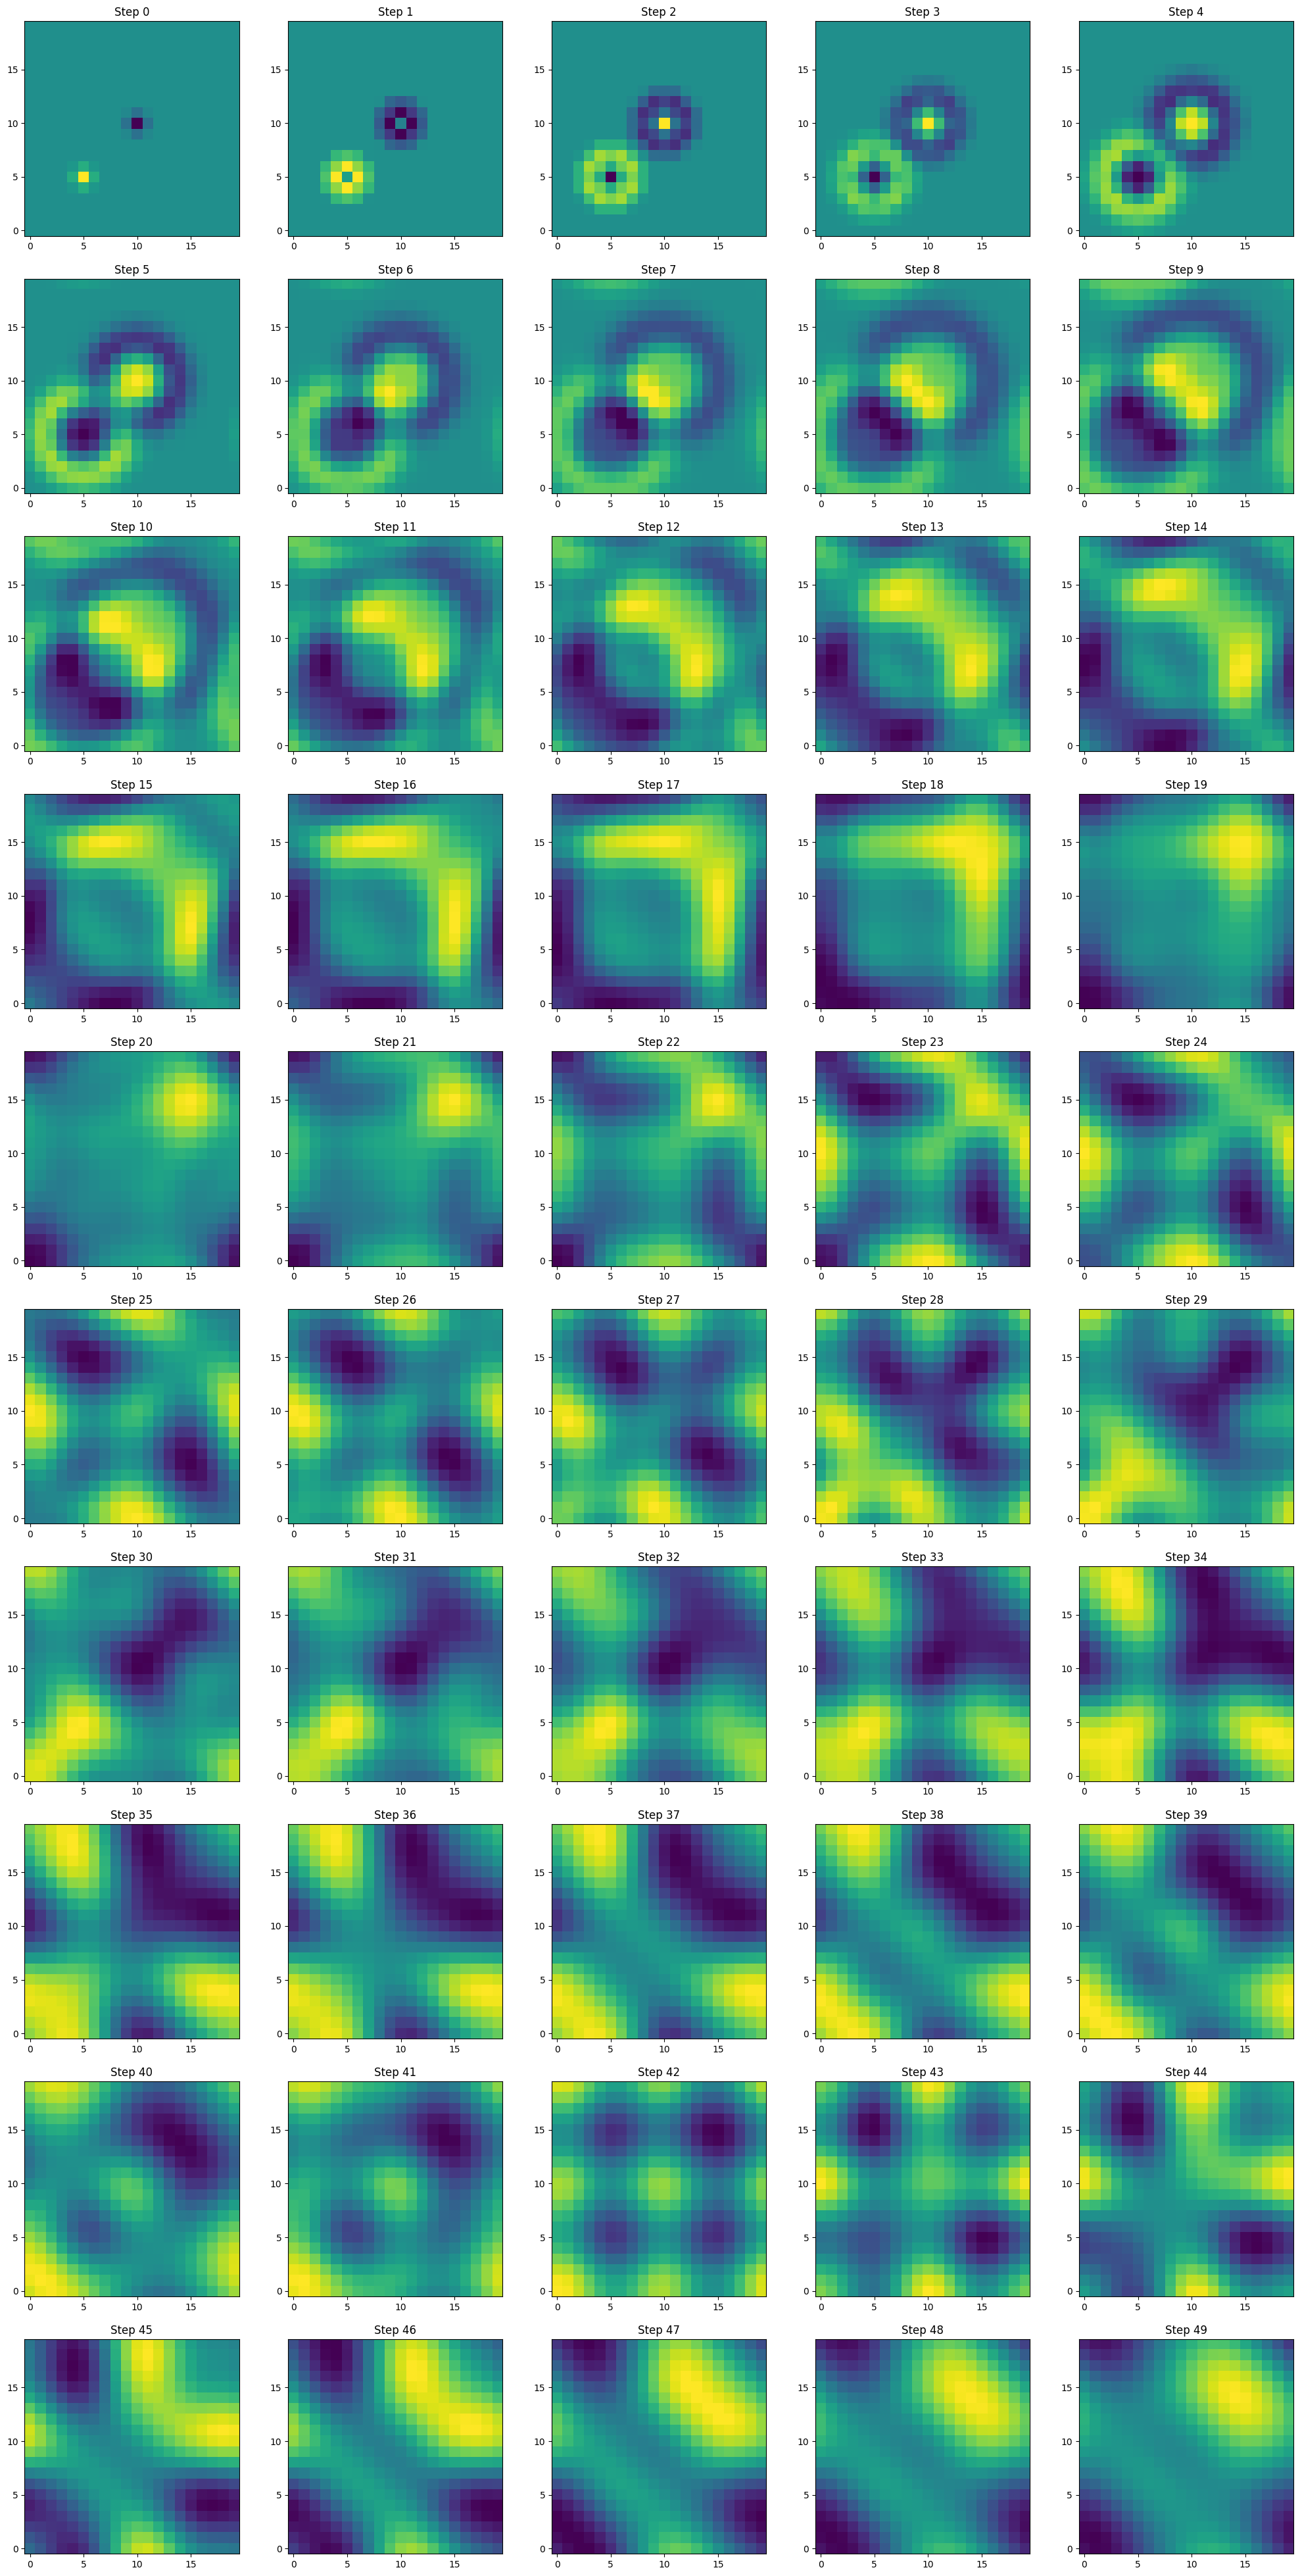

In [142]:
%matplotlib inline

f = np.einsum("i,jk->ijk", w_i, np.ones((nx, ny)))
f[:, nx//2, ny//2] = 0.99*f[:, nx//2, ny//2]
f[:, nx//4, ny//4] = 1.01*f[:, nx//4, ny//4]

slen = 50
subplot_columns = 5
subplot_rows = slen//subplot_columns
fig, axes = plt.subplots(subplot_rows, subplot_columns)
plt.setp(axes, xticks=range(0,nx+1,5), yticks=range(0,ny+1,5))
plt.gcf().set_size_inches(subplot_columns*5,subplot_rows*5)
for i in range(slen):
    f = shear_wave_decay(f)
    plot_density(get_rho(f), axes[i//subplot_columns, i%subplot_columns], f"Step {i}")


## Simulate 

In [143]:
def simulate_shear_wave_decay(f, iter_length, value_log_period, config_title=None, plot=True):
    slen = math.ceil(iter_length/value_log_period)
    u_periodic = np.empty((slen, ny+2))
    r_periodic = np.empty((slen, ny+2))
    u_amplitude = np.empty((slen))
    r_amplitude = np.empty((slen))
    
    if plot:
        subplot_columns = 5
        subplot_rows = math.ceil(slen/subplot_columns)
        fig, axes = plt.subplots(subplot_rows, subplot_columns)
        plt.setp(axes, xticks=range(0,nx+1,5), yticks=range(0,ny+1,5))
        plt.gcf().set_size_inches(subplot_columns*5,subplot_rows*5)
        if config_title:
            plt.suptitle(config_title)

    for i in range(iter_length):
        f = couette(f)
        rho = get_rho(f)
        u = get_u(f,rho)
        if i%value_log_period==0:
            idx = math.ceil(i/value_log_period)
            u_periodic[idx] = u[0,nx//2,:]
            u_amplitude[idx] = max(u_periodic[idx])
            r_periodic[idx] = rho[nx//2,:]
            r_amplitude[idx] = max(r_periodic[idx])
            
            if plot:
                axis = axes[math.ceil(idx/subplot_columns), idx%subplot_columns]

                plot_density(get_rho(f), axis, f"Step {i}")
                axis.streamplot(X, Y, u[0].T, u[1].T)

    return u_periodic, r_periodic, u_amplitude, r_amplitude


### Calculate with values: 

𝜌(𝐫,0)=𝜌0+𝜀sin(2𝜋𝑥/𝐿𝑥)  and 𝐮(𝐫,0)=0

0
100
200
300
400
500
600
700
800
900


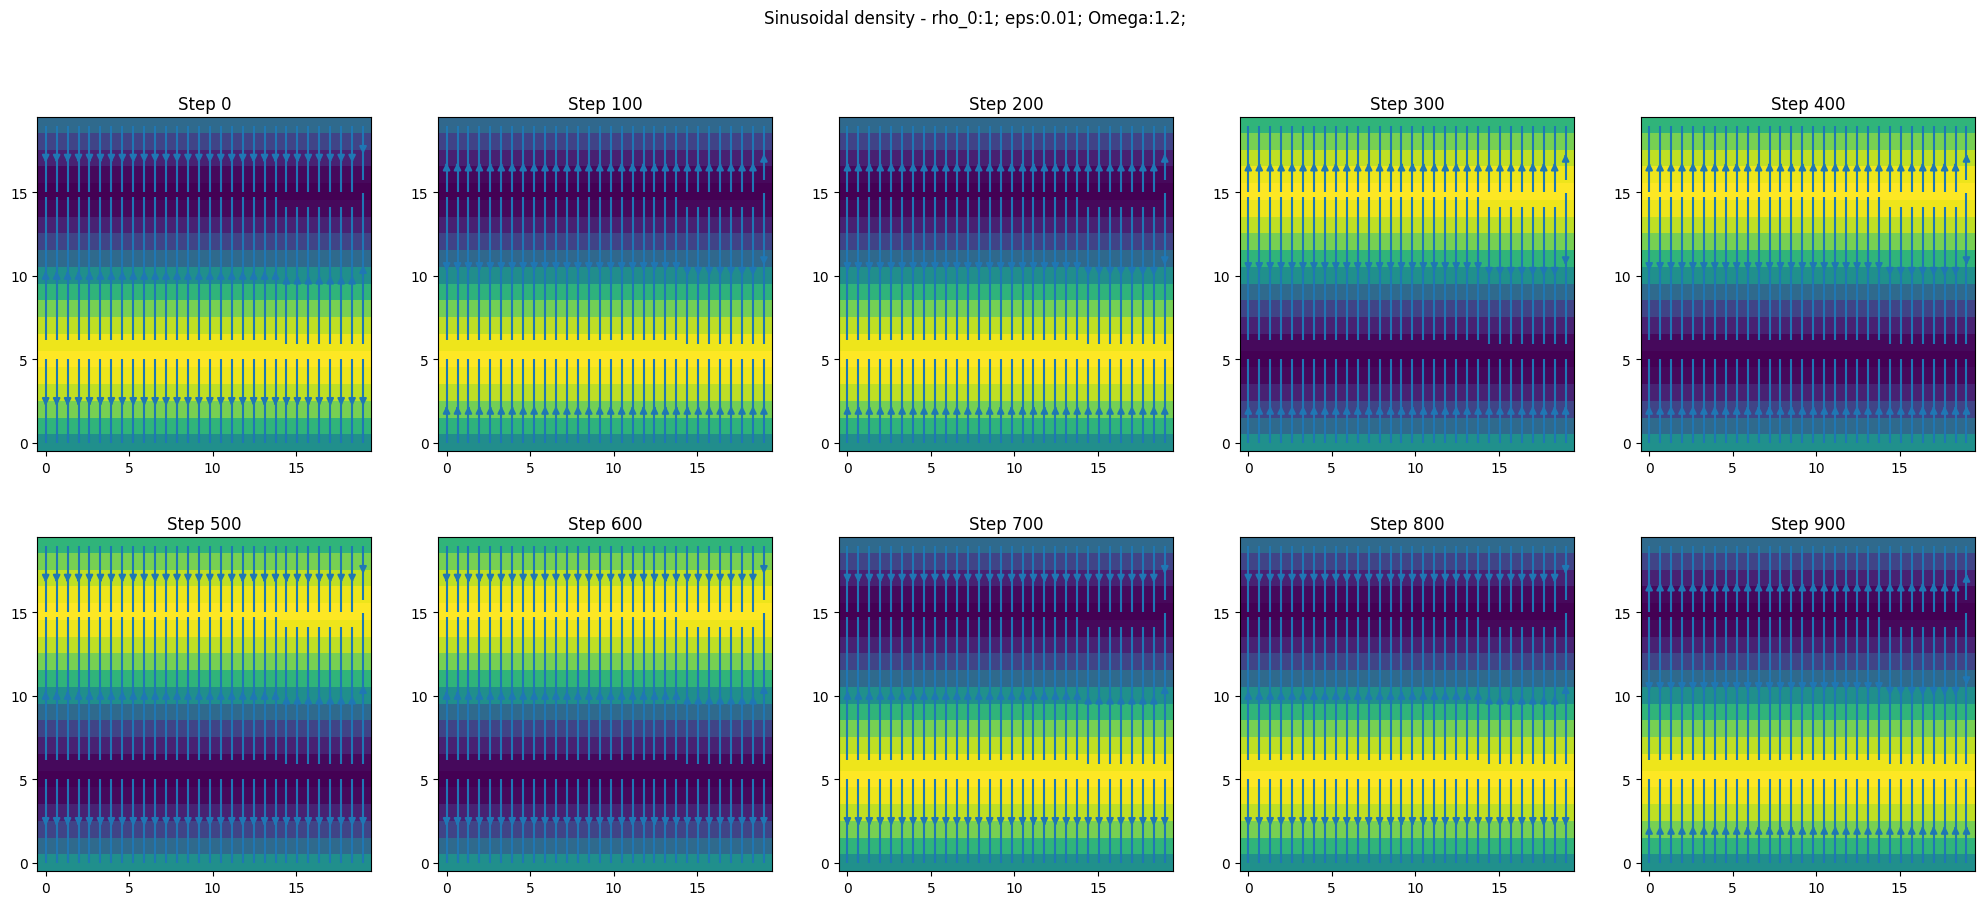

In [144]:
u_init = np.zeros((a, nx, ny))
rho_init = rho_o + epsilon*np.sin((2.*np.pi*X)/L)

f = np.einsum("i,jk->ijk", w_i, rho_init)

log_timestep = 100
config_title = f"Sinusoidal density - rho_0:{rho_o}; eps:{epsilon}; Omega:{omega};"

u_periodic, r_periodic, u_amplitude, r_amplitude = \
simulate_shear_wave_decay(f, 1000, log_timestep, config_title)

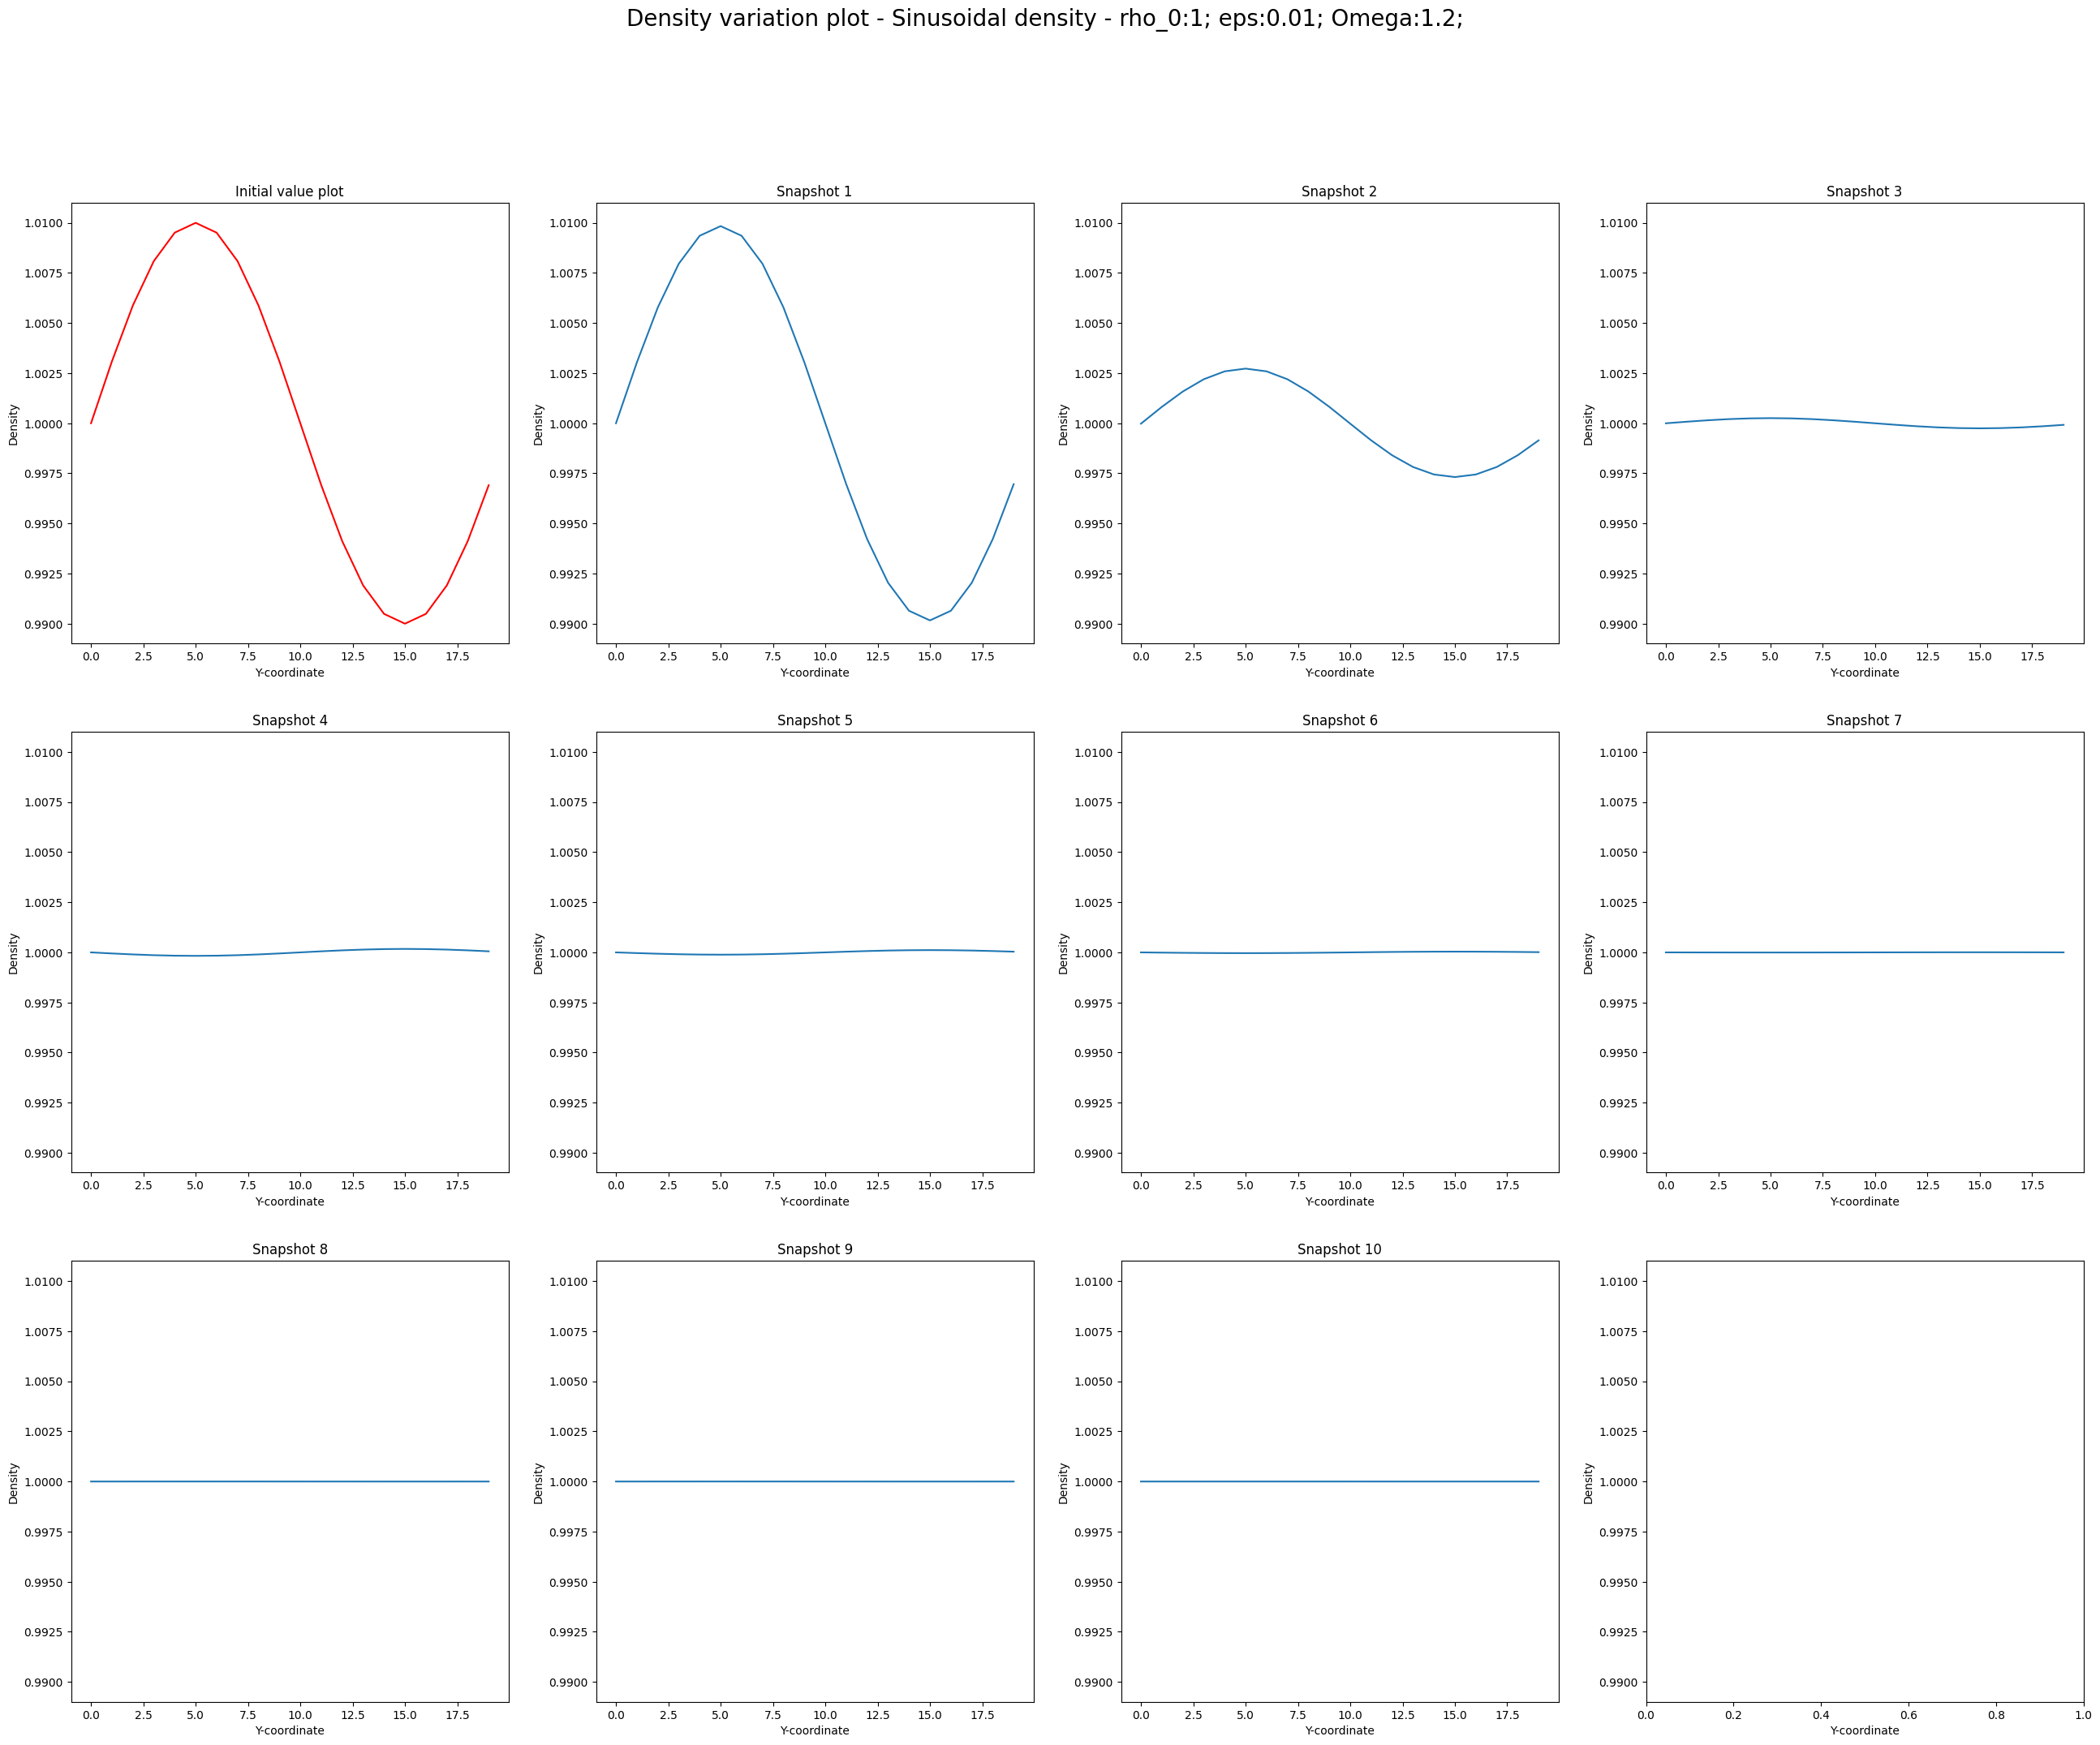

In [145]:
# Wave decay
plot_decay(r_periodic, "Y-coordinate", "Density", "Density variation plot - "+config_title, rho_init[nx//2], )


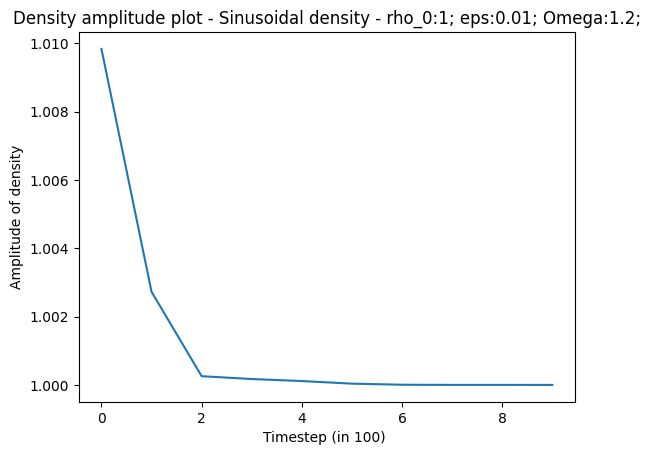

In [146]:
# Amplitude plot

plot_amplitude(r_amplitude, f"Timestep (in {log_timestep}) ", "Amplitude of density", "Density amplitude plot - "+config_desc)

### Calculate with values: 

𝜌(𝐫,0)=1  and 𝑢𝑥(𝐫,0)=𝜀sin(2𝜋𝑦𝐿𝑦)

0
100
200
300
400
500
600
700
800
900


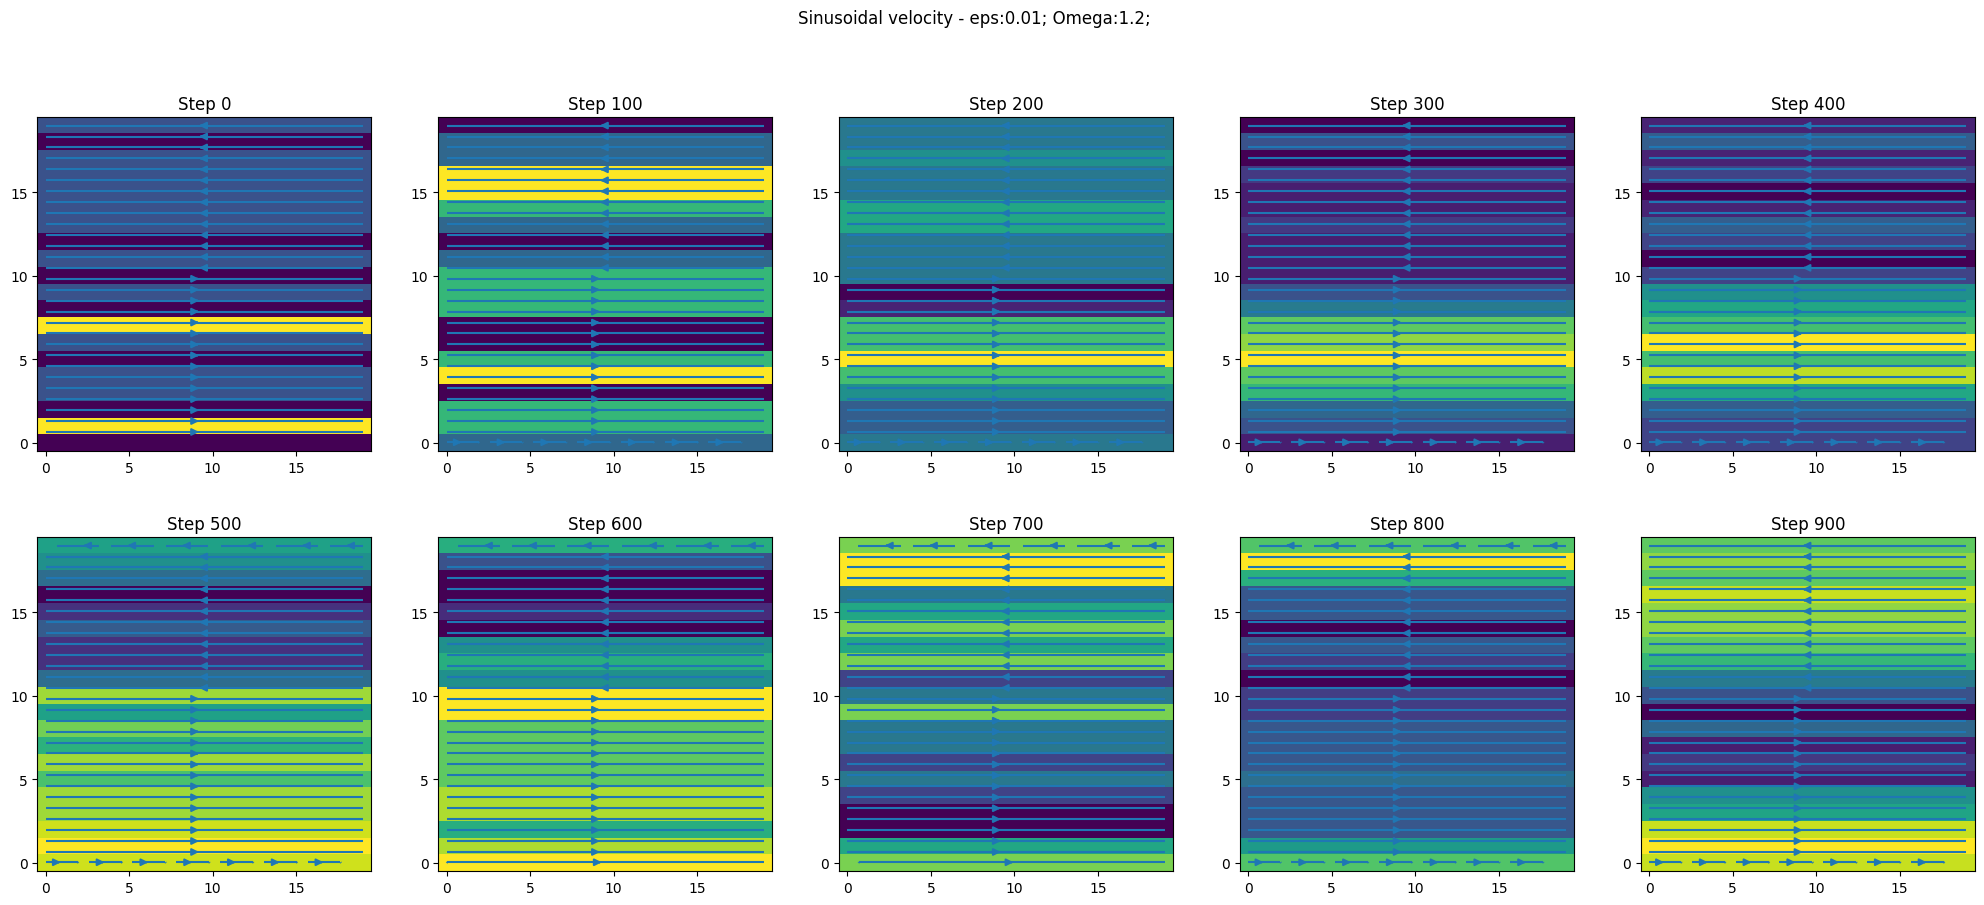

In [147]:
rho_init = np.ones((nx, ny))

ux = epsilon*np.sin((2.*np.pi*X)/L)
uy = np.zeros((nx,ny))
u_init = np.stack((ux,uy), axis = 0)

f = equilibrium(rho_init, u_init)

log_timestep = 100
config_title = f"Sinusoidal velocity - eps:{epsilon}; Omega:{omega};"

u_periodic, r_periodic, u_amplitude, r_amplitude = \
simulate_shear_wave_decay(f, 1000, log_timestep, config_title)

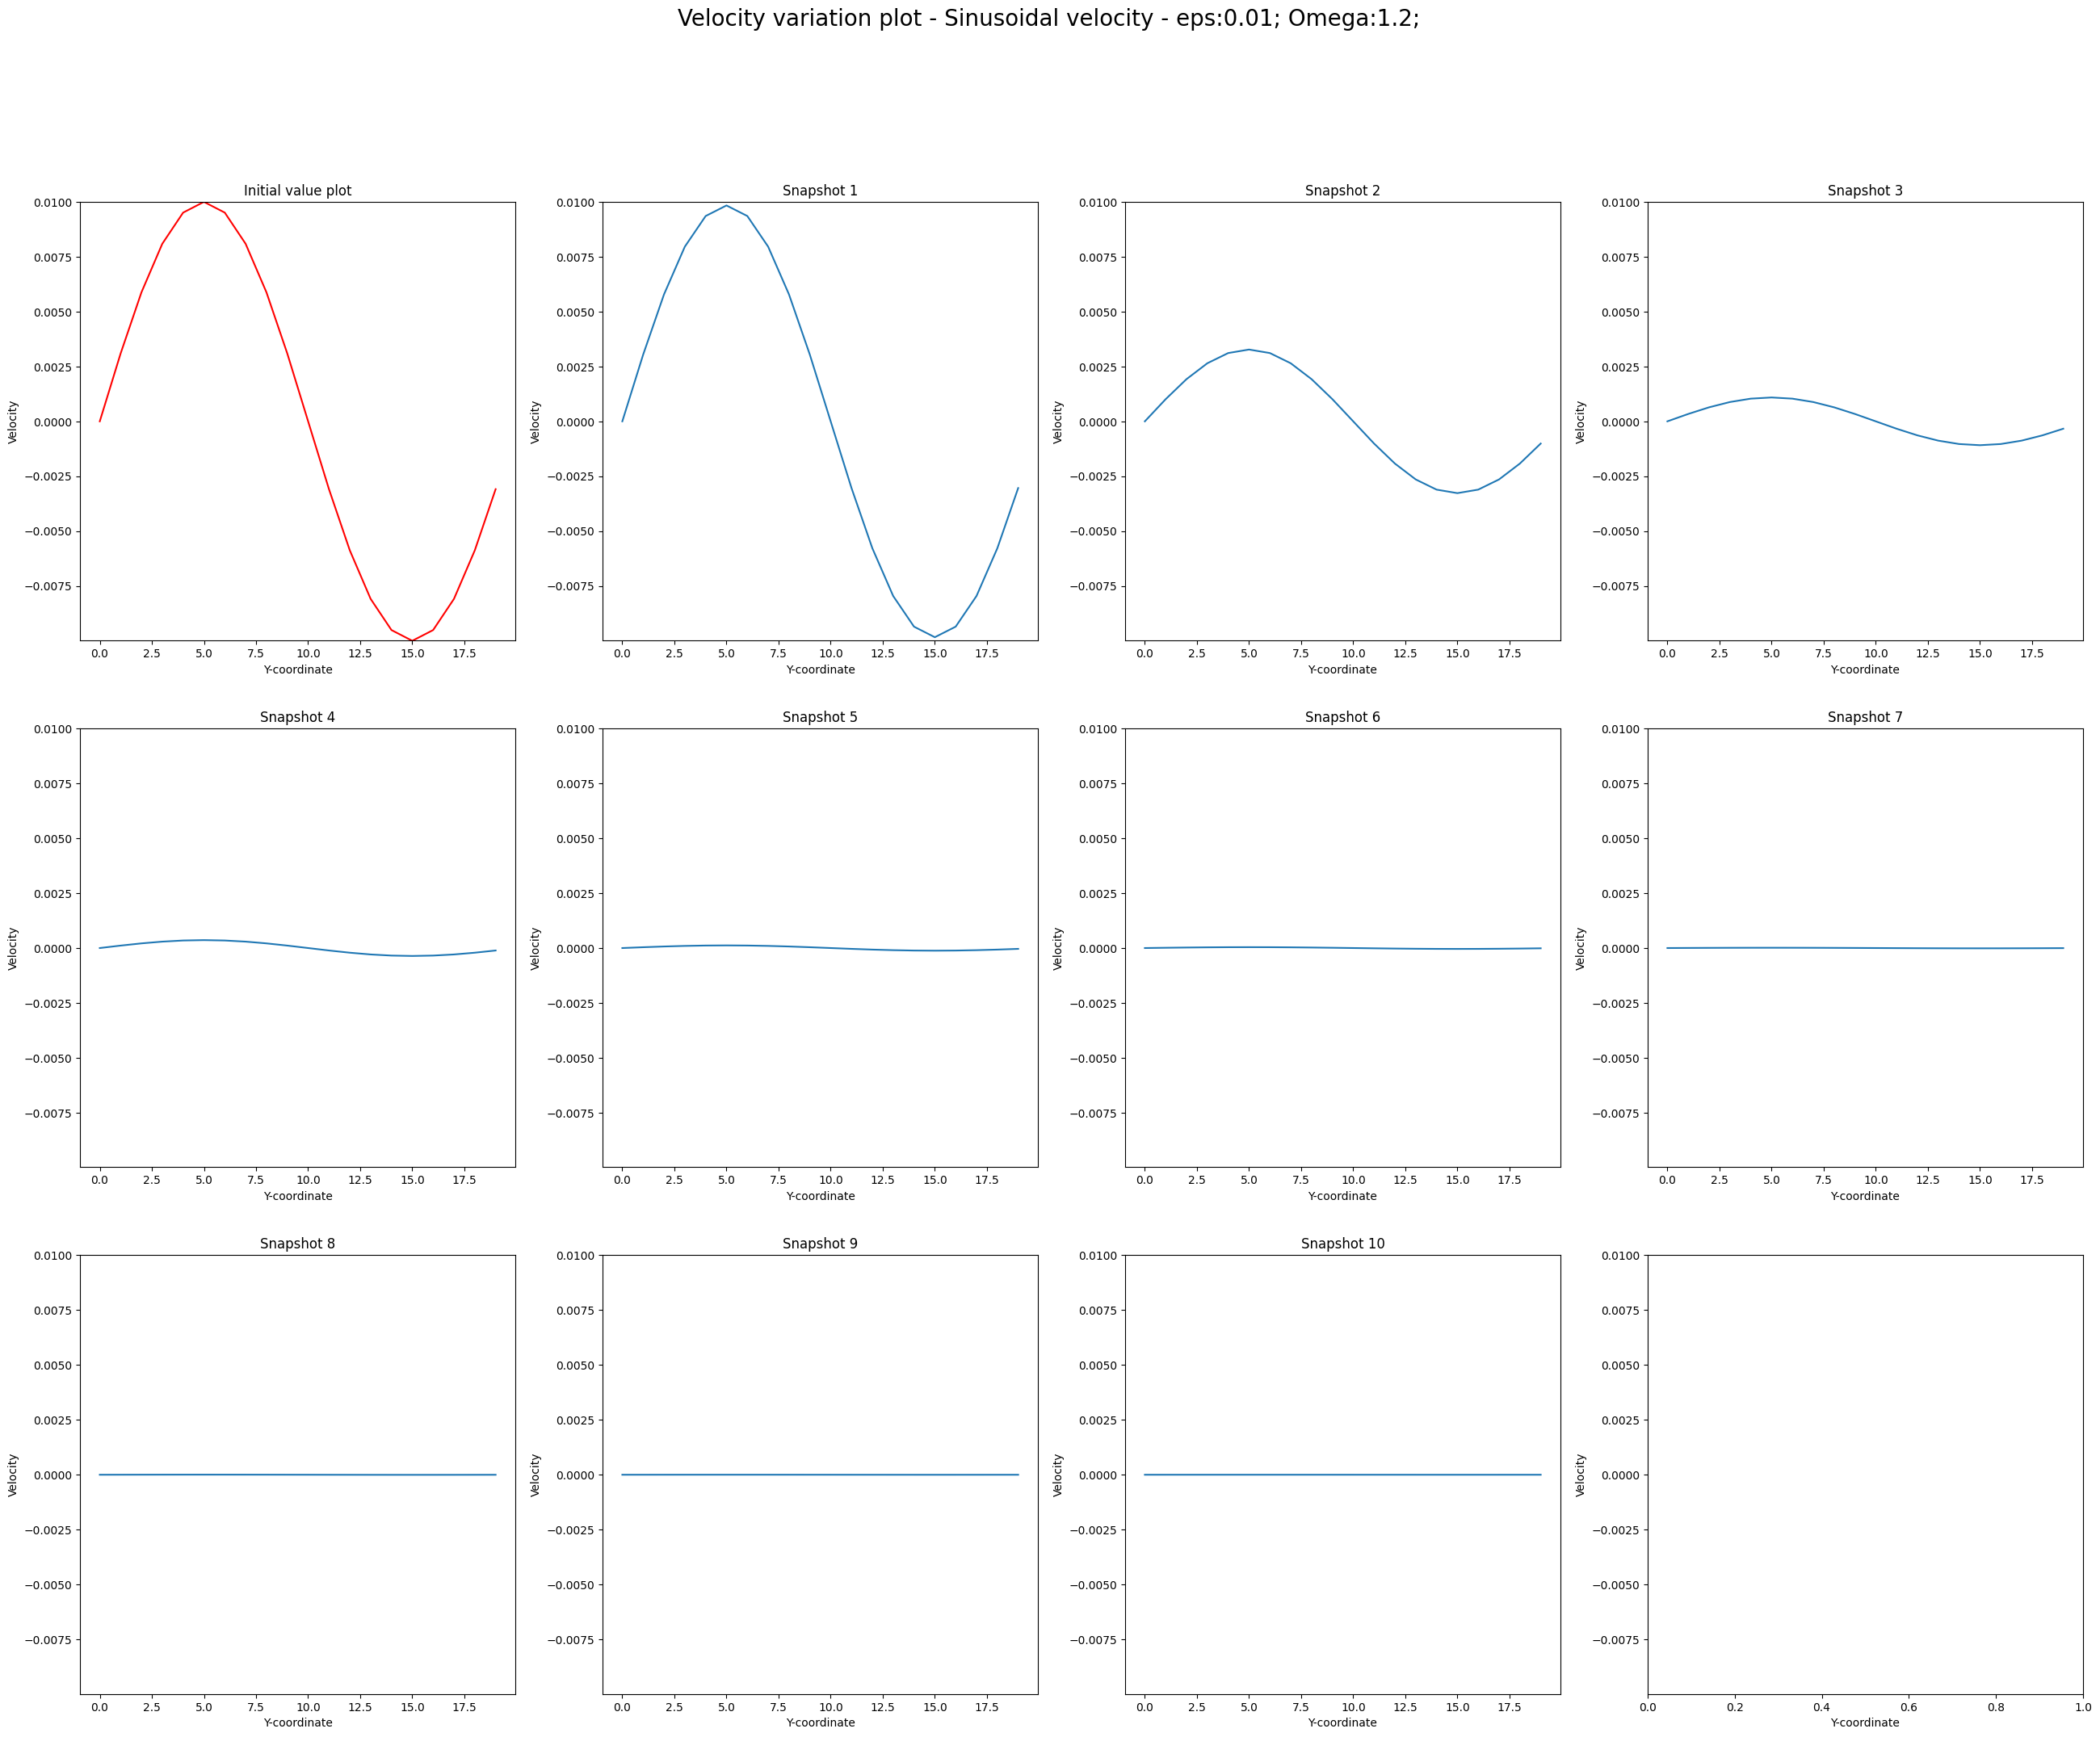

In [148]:
# Wave decay - plot of velocity

plot_decay(u_periodic, "Y-coordinate", "Velocity", "Velocity variation plot - "+config_title, u_init[0,nx//2,:])

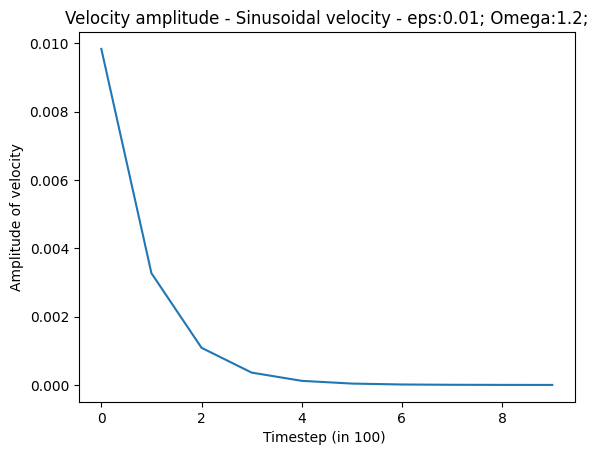

In [149]:
# Amplitude plot
plot_amplitude(u_amplitude, f"Timestep (in {log_timestep}) ", "Amplitude of velocity", "Velocity amplitude plot - "+f"Sinusoidal velocity - eps:{epsilon}; Omega:{omega};")

### Omega and viscosity plot

Omega value: 0.26
0
100
200
300
400
500
600
700
800
900
Omega value: 0.41
0
100
200
300
400
500
600
700
800
900
Omega value: 0.57
0
100
200
300
400
500
600
700
800
900
Omega value: 0.72
0
100
200
300
400
500
600
700
800
900
Omega value: 0.88
0
100
200
300
400
500
600
700
800
900
Omega value: 1.03
0
100
200
300
400
500
600
700
800
900
Omega value: 1.19
0
100
200
300
400
500
600
700
800
900
Omega value: 1.34
0
100
200
300
400
500
600
700
800
900
Omega value: 1.5
0
100
200
300
400
500
600
700
800
900


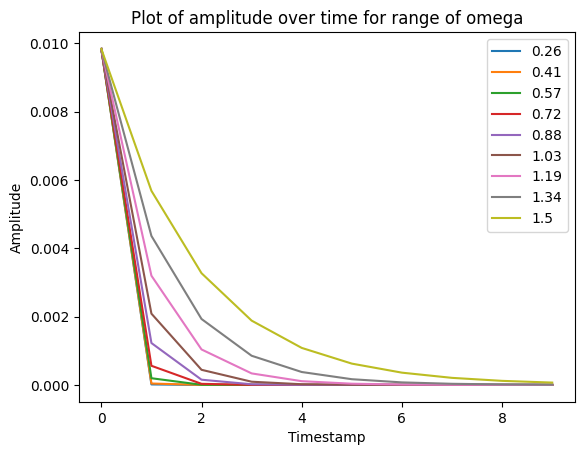

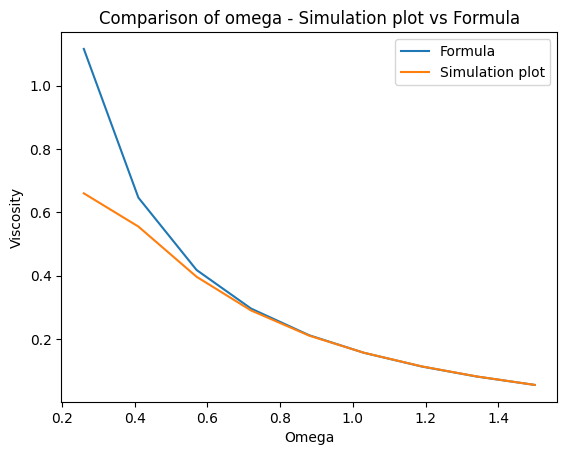

In [160]:
# omega_list = np.linspace(0.1, 1.5, 10)[1:]
omega_list = np.round(np.linspace(0.1, 1.5, 10)[1:],2)
viscosities = np.zeros((len(omega_list), 3))


for idx, value in enumerate(omega_list):
    print(f"Omega value: {value}")
    omega = value
    rho_init = np.ones((nx, ny))
    u_init = np.stack((epsilon*np.sin((2.*np.pi*X)/L),
                       np.zeros((nx,ny))), 
                      axis = 0)
    f = equilibrium(rho_init, u_init)
    _, _, u_amplitude, _ = simulate_shear_wave_decay(f, 1000, log_timestep, plot=False)
    
    plot_amplitude(u_amplitude, f"Timestep (in {log_timestep}) ", "Amplitude of velocity")
    
    a_0 = u_amplitude[0]
    a_1 = u_amplitude[1]
    k = (2.*np.pi)/L
    visc_plot = (np.log(a_0)-np.log(a_1))/(k*k*log_timestep)
    
    visc_calc = (1/3)*((1/omega)-0.5)
    viscosities[idx][:] = omega, visc_calc, visc_plot 

plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.title("Plot of amplitude over time for range of omega")
plt.legend(omega_list)
plt.show()

viscosities = viscosities.T
plt.plot(viscosities[0], viscosities[1], label="Formula")
plt.plot(viscosities[0], viscosities[2], label="Simulation plot")
plt.xlabel("Omega")
plt.ylabel("Viscosity")
plt.title("Comparison of omega - Simulation plot vs Formula")
plt.legend()
plt.show()